<a href="https://colab.research.google.com/github/NishanthAR-droid/Pump_predictive_maintenance/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the first CSV file into a DataFrame
df1 = pd.read_csv('combined_data(26feb to 20 mar).csv')

# Load the second CSV file into another DataFrame
df2 = pd.read_csv('combined_data(21 mar to 2 apr).csv')

# Concatenate the two DataFrames along the rows axis (vertically)
combined_df = pd.concat([df1, df2], ignore_index=True)

# Write the combined DataFrame to a new CSV file
combined_df.to_csv('combined_data1.csv', index=False)
combined_df.shape

(22732, 27)

# **preprocess data**

In [ ]:
import pandas as pd
import numpy as np


def calculate_rms(row):
    return np.sqrt(np.mean(row ** 2))

def preprocess_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()

    # Drop the "water level" column
    df.drop(df.columns[25], axis=1, inplace=True)

    # Check for null or 0 values
    null_or_zero_rows = df.isnull().any(axis=1) | (df == 0).any(axis=1)

    # Remove rows with null or 0 values
    df = df[~null_or_zero_rows]

    # Add header at the first row by deleting the existing row
    header = ["pump_Id", "date", "timestamp", "Vr", "Vy", "Vb", "Ir", "Iy", "Ib", "freq", "power", "pf",
              "MNDE_temp", "MDE_temp", "PNDE_temp", "PDE_temp", "MNDE_vib", "MDE_vib", "PNDE_vib",
              "PDE_vib", "speed", "pump_eff", "motor_eff", "combined_eff", "water_flow", "head"]
    df.columns = header

    df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp')
    df['voltage_RMS'] = df[['Vr', 'Vy', 'Vb']].apply(calculate_rms,axis=1)
    df['current_RMS'] = df[['Ir', 'Iy', 'Ib']].apply(calculate_rms,axis=1)

    # Overwrite the original file with preprocessed data
    df.to_csv("preprocess.csv", index=False)

# Example usage
preprocess_csv("combined_data1.csv")

df = pd.read_csv("preprocess.csv")

def calculate_rms(row):
    return np.sqrt(np.mean(row ** 2))

df['voltage_RMS'] = df[['Vr', 'Vy', 'Vb']].apply(calculate_rms,axis=1)
df['current_RMS'] = df[['Ir', 'Iy', 'Ib']].apply(calculate_rms,axis=1)

df.to_csv("preprocess.csv", index=False)
print(df.shape)
print(df.head())
# Print the total number of entries
total_entries = df.shape[0]
print("Total number of entries:", total_entries)

(6710, 28)
   pump_Id        date            timestamp           Vr           Vy  \
0  Pump 01  02-26-2024  2024-02-26 15:34:35  6512.258789  6646.126465   
1  Pump 01  02-26-2024  2024-02-26 16:21:55  6768.656738  6906.000977   
2  Pump 01  02-26-2024  2024-02-26 16:24:39  6736.769531  6876.208008   
3  Pump 01  02-26-2024  2024-02-26 16:27:28  6725.375488  6863.557129   
4  Pump 01  02-26-2024  2024-02-26 16:33:02  6702.876953  6841.943848   

            Vb          Ir          Iy          Ib       freq  ...  PNDE_vib  \
0  6606.902344  128.813583  129.891769  126.901161  49.952621  ...  3.377428   
1  6866.155762  124.131844  125.164635  121.921127  49.984249  ...  3.111335   
2  6832.993652  124.243103  125.303185  121.940392  49.942886  ...  3.247729   
3  6819.385254  124.026619  124.980347  121.713524  49.863087  ...  3.330099   
4  6797.928223  125.781494  126.950562  123.485809  50.043442  ...  3.207304   

    PDE_vib        speed   pump_eff  motor_eff  combined_eff  water_f

#Labelling all data

In [ ]:
import pandas as pd
import numpy as np


filename="preprocess"

df = pd.read_csv(filename +".csv")
df=df.iloc[:,:20].drop_duplicates()
df = df[(df != 0).all(axis=1)]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.sort_values(by='timestamp')

def calculate_rms(row):
    return np.sqrt(np.mean(row ** 2))

def classify_vibration(vibration):
    if vibration < 4.2:
        return 'normal'
    elif vibration < 7.2:
        return 'alarm'
    else:
        return 'shutdown'

def classify_temperature(temperature):
    if temperature<49:
        return 'normal'
    elif temperature < 54:
        return 'alarm'
    else:
        return 'shutdown'

def classify_power_I(value,rated_value):
    percentage_difference = abs(value - rated_value) / rated_value * 100
    if percentage_difference < 3.5:
        return 'normal'
    elif percentage_difference < 6:
        return 'alarm'
    else:
        return 'shutdown'

def classify_V(value,rated_value):
    percentage_difference = abs(value - rated_value) / rated_value * 100
    if percentage_difference < 6:
        return 'normal'
    elif percentage_difference < 8:
        return 'alarm'
    else:
        return 'shutdown'

def determine_final_class(row):
    last_four_columns = row[-4:]  # Consider only the last four columns
    if 'shutdown' in last_four_columns.values:
        return 'shutdown'
    elif 'alarm' in last_four_columns.values:
        return 'alarm'
    else:
        return 'normal'


df['voltage_RMS'] = df[['Vr', 'Vy', 'Vb']].apply(calculate_rms,axis=1)
df['current_RMS'] = df[['Ir', 'Iy', 'Ib']].apply(calculate_rms,axis=1)
df['power']=(np.sqrt(3) * df['voltage_RMS'] * df['current_RMS'] * df['pf'])/1000

df['V_class'] = df['voltage_RMS'].apply(classify_V,rated_value=6600)
df['I_class'] = df['current_RMS'].apply(classify_power_I,rated_value=125)
df['P_class'] = df['power'].apply(classify_power_I,rated_value=1250)

df['MNDE_temp_class'] = df['MNDE_temp'].apply(classify_temperature)
df['MDE_temp_class'] = df['MDE_temp'].apply(classify_temperature)
df['PNDE_temp_class'] = df['PNDE_temp'].apply(classify_temperature)
df['PDE_temp_class'] = df['PDE_temp'].apply(classify_temperature)
df['temperature_class'] = df.apply(determine_final_class, axis=1)

df['MNDE_vib_class'] = df['MNDE_vib'].apply(classify_vibration)
df['MDE_vib_class'] = df['MDE_vib'].apply(classify_vibration)
df['PNDE_vib_class'] = df['PNDE_vib'].apply(classify_vibration)
df['PDE_vib_class'] = df['PDE_vib'].apply(classify_vibration)
df['vibration_class'] = df.apply(determine_final_class, axis=1)



df.to_csv(filename + "_labeled.csv", index=False)

value_counts = df['V_class'].value_counts()
print(value_counts)
value_counts = df['I_class'].value_counts()
print(value_counts)
value_counts = df['P_class'].value_counts()
print(value_counts)
value_counts = df['temperature_class'].value_counts()
print(value_counts)
value_counts = df['vibration_class'].value_counts()
print(value_counts)

print(df.shape)
df.head()

V_class
normal      6426
alarm        268
shutdown      16
Name: count, dtype: int64
I_class
normal      5544
alarm       1038
shutdown     128
Name: count, dtype: int64
P_class
normal      4864
alarm       1792
shutdown      54
Name: count, dtype: int64
temperature_class
normal      6367
alarm        341
shutdown       2
Name: count, dtype: int64
vibration_class
normal    6710
Name: count, dtype: int64
(6710, 35)


,pump_Id,date,timestamp,Vr,Vy,Vb,Ir,Iy,Ib,freq,...,MNDE_temp_class,MDE_temp_class,PNDE_temp_class,PDE_temp_class,temperature_class,MNDE_vib_class,MDE_vib_class,PNDE_vib_class,PDE_vib_class,vibration_class
0,Pump 01,02-26-2024,2024-02-26 15:34:35,6512.258789,6646.126465,6606.902344,128.813583,129.891769,126.901161,49.952621,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1,Pump 01,02-26-2024,2024-02-26 16:21:55,6768.656738,6906.000977,6866.155762,124.131844,125.164635,121.921127,49.984249,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
2,Pump 01,02-26-2024,2024-02-26 16:24:39,6736.769531,6876.208008,6832.993652,124.243103,125.303185,121.940392,49.942886,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
3,Pump 01,02-26-2024,2024-02-26 16:27:28,6725.375488,6863.557129,6819.385254,124.026619,124.980347,121.713524,49.863087,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,Pump 01,02-26-2024,2024-02-26 16:33:02,6702.876953,6841.943848,6797.928223,125.781494,126.950562,123.485809,50.043442,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal


# Generate synthetic voltage data for classification

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


# Define the number of rows in the dataset
num_rows = 10000

# Generate random values for each column
Vr = np.random.uniform(low=6000.0, high=7400.0, size=num_rows).round(6)
Vy = np.random.uniform(low=6000.0, high=7400.0, size=num_rows).round(6)
Vb = np.random.uniform(low=6000.0, high=7400.0, size=num_rows).round(6)


# Create a DataFrame
df = pd.DataFrame({
    'Vr': Vr,
    'Vy': Vy,
    'Vb': Vb,
})

def classify_V(value,rated_value):
    percentage_difference = abs(value - rated_value) / rated_value * 100
    if percentage_difference < 6:
        return 'normal'
    elif percentage_difference < 8:
        return 'alarm'
    else:
        return 'shutdown'

def calculate_rms(row):
    return np.sqrt(np.mean(row ** 2))

df['voltage_RMS'] = df[['Vr', 'Vy', 'Vb']].apply(calculate_rms,axis=1)
df['V_class'] = df['voltage_RMS'].apply(classify_V,rated_value=6600)


value_counts = df['V_class'].value_counts()
print(value_counts)


# Display the first few rows of the dataset
print(df.head())



#balance dataset
X = df.iloc[:,:3]  # Features
y = df['V_class']  # Labels

# Identify minority class
minority_class = y.value_counts().idxmin()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Optional: Shuffle the dataset
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)

resampled_df['voltage_RMS'] = resampled_df[['Vr', 'Vy', 'Vb']].apply(calculate_rms,axis=1)
resampled_df['V_class'] = resampled_df['voltage_RMS'].apply(classify_V,rated_value=6600)

resampled_df.to_csv("voltage_synthetic_SMOTE.csv", index=False)

value_counts = resampled_df['V_class'].value_counts()
print(value_counts)
print(resampled_df.shape)
resampled_df.head()

V_class
normal      8749
alarm        908
shutdown     343
Name: count, dtype: int64
            Vr           Vy           Vb  voltage_RMS V_class
0  6028.163469  6895.570640  6418.712712  6457.231660  normal
1  6968.522300  6668.721621  6412.425489  6687.085856  normal
2  6329.147196  7197.136301  6797.120582  6783.748309  normal
3  6243.947655  7368.164729  6931.878721  6863.616063  normal
4  6725.264592  6156.416630  6691.870267  6529.721210  normal
V_class
normal      8749
alarm       8749
shutdown    8749
Name: count, dtype: int64
(26247, 5)


,Vr,Vy,Vb,V_class,voltage_RMS
0,6859.903445,6360.677321,7004.173671,normal,6747.220170
1,7135.320625,7298.942195,6054.185571,normal,6851.776425
2,7206.780599,7266.506568,6721.255144,alarm,7069.065827
3,7089.869667,7386.296235,6980.292767,shutdown,7154.208810
4,6849.423340,7337.297586,6897.439760,alarm,7031.481854


# **voltage classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Read the CSV file
df = pd.read_csv("preprocess_labeled.csv")

# Separate features (X) and target variable (y)
X = df[['Vr','Vy','Vb','voltage_RMS']]# Specify the column containing features
y = df['V_class']  # Specify the column containing target variable
label_map={"normal":0,"alarm":1,"shutdown":2}
y = y.map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#----------------------------KNN------------------------------------------------------------------
# Create a KNN classifier with k=5 (you can choose the value of k)
knn = KNeighborsClassifier(n_neighbors=5)
# Train the classifier on the training data
knn.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))


#----------------------------SVM------------------------------------------------------------------
svm = SVC(kernel='rbf',probability=True)
# Train the classifier on the training data
svm.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = svm.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------Xgboost------------------------------------------------------------------
xgb = XGBClassifier()
# Train the classifier on the training data
xgb.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------Random forest------------------------------------------------------------------
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=90)


#----------------------------cross validation------------------------------------------------------------------
# cv_scores = cross_val_score(rf, X, y, cv=10, scoring='accuracy')  # 5-fold cross-validation

# # Print the cross-validation scores
# print("Cross-validation scores:", cv_scores)
# print("Mean CV Accuracy:", np.mean(cv_scores))
#----------------------------cross validation------------------------------------------------------------------


# Train the classifier on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------combined------------------------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)

#----------------------------roc------------------------------------------------------------------
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from scipy import interp

# # Binarize the labels
# y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
# n_classes = y_test_binarized.shape[1]

# # Get the predicted probabilities for each class
# y_prob = vc.predict_proba(X_test)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='Micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

# #----------------------------roc------------------------------------------------------------------

# # Evaluate the classifier
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

#----------------------------save model------------------------------------------------------------------
import joblib
# Assuming 'model' is the variable name of your trained model
joblib.dump(vc, 'voltage_classifier.joblib')

joblib.__version__

loaded_model = joblib.load('voltage_classifier.joblib')
df = pd.read_csv("preprocess_labeled.csv")
df=df.loc[:,['Vr','Vy','Vb','voltage_RMS','V_class']]
features=['Vr','Vy','Vb','voltage_RMS']
df['final_class']=loaded_model.predict(df[features])
df.to_csv("V_SMOTE.csv", index=False)

value_counts = df['V_class'].value_counts()
print(value_counts)
value_counts = df['final_class'].value_counts()
print(value_counts)


[[1918    1    0]
 [   1   84    0]
 [   0    0    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1919
           1       0.99      0.99      0.99        85
           2       1.00      1.00      1.00         9

    accuracy                           1.00      2013
   macro avg       1.00      1.00      1.00      2013
weighted avg       1.00      1.00      1.00      2013



# Generate synthetic current data for classification

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


# Define the number of rows in the dataset
num_rows = 10000

# Generate random values for each column
Ir = np.random.uniform(low=90.0, high=150.0, size=num_rows).round(6)
Iy = np.random.uniform(low=90.0, high=150.0, size=num_rows).round(6)
Ib = np.random.uniform(low=90.0, high=150.0, size=num_rows).round(6)


# Create a DataFrame
df = pd.DataFrame({
    'Ir': Ir,
    'Iy': Iy,
    'Ib': Ib,
})

def classify_power_I(value,rated_value):
    percentage_difference = abs(value - rated_value) / rated_value * 100
    if percentage_difference < 3.5:
        return 'normal'
    elif percentage_difference < 6:
        return 'alarm'
    else:
        return 'shutdown'

def calculate_rms(row):
    return np.sqrt(np.mean(row ** 2))

df['current_RMS'] = df[['Ir', 'Iy', 'Ib']].apply(calculate_rms,axis=1)
df['I_class'] = df['current_RMS'].apply(classify_power_I,rated_value=125)


value_counts = df['I_class'].value_counts()
print(value_counts)


# Display the first few rows of the dataset
df



#balance dataset
X = df.iloc[:,:3]  # Features
y = df['I_class']  # Labels

# Identify minority class
minority_class = y.value_counts().idxmin()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Optional: Shuffle the dataset
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)

resampled_df['current_RMS'] = resampled_df[['Ir', 'Iy', 'Ib']].apply(calculate_rms,axis=1)
resampled_df['I_class'] = resampled_df['current_RMS'].apply(classify_power_I,rated_value=125)

resampled_df.to_csv("current_synthetic_SMOTE.csv", index=False)

value_counts = resampled_df['I_class'].value_counts()
print(value_counts)
print(resampled_df.shape)
resampled_df

I_class
normal      4844
shutdown    4844
alarm       4844
Name: count, dtype: int64
(14532, 5)


,Ir,Iy,Ib,I_class,current_RMS
0,136.365849,128.093692,111.846082,normal,125.848036
1,112.021177,113.840248,114.821890,shutdown,113.567032
2,112.830604,141.030786,137.942114,alarm,131.210333
3,109.729514,105.925220,148.902931,normal,123.062046
4,109.279550,107.303676,146.311675,normal,122.288191
...,...,...,...,...,...
14527,130.093949,114.895573,92.497175,shutdown,113.550511
14528,121.338402,121.683486,121.800640,normal,121.607668
14529,94.975425,94.220507,110.122927,shutdown,100.041482
14530,134.855092,97.018355,130.231546,normal,121.872492


# **current classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Read the CSV file
df = pd.read_csv("preprocess_labeled.csv")

# Separate features (X) and target variable (y)
X = df[['Ir','Iy','Ib','current_RMS']]# Specify the column containing features
y = df['I_class']  # Specify the column containing target variable
label_map={"normal":0,"alarm":1,"shutdown":2}
y = y.map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#----------------------------KNN------------------------------------------------------------------
# Create a KNN classifier with k=5 (you can choose the value of k)
knn = KNeighborsClassifier(n_neighbors=5)
# Train the classifier on the training data
knn.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))


#----------------------------SVM------------------------------------------------------------------
svm = SVC(kernel='rbf',probability=True)
# Train the classifier on the training data
svm.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = svm.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------Xgboost------------------------------------------------------------------
xgb = XGBClassifier()
# Train the classifier on the training data
xgb.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Random forest------------------------------------------------------------------
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=1)
# Train the classifier on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------combined------------------------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------save model------------------------------------------------------------------
import joblib
# Assuming 'model' is the variable name of your trained model
joblib.dump(vc, 'current_classifier.joblib')



loaded_model = joblib.load('current_classifier.joblib')
df = pd.read_csv("preprocess_labeled.csv")
df=df.loc[:,['Ir','Iy','Ib','current_RMS','I_class']]
features=['Ir','Iy','Ib','current_RMS']
df['final_class']=loaded_model.predict(df[features])
df.to_csv("I_SMOTE.csv", index=False)

value_counts = df['I_class'].value_counts()
print(value_counts)
value_counts = df['final_class'].value_counts()
print(value_counts)

[[1672    4    0]
 [   8  295    0]
 [   0    2   32]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1676
           1       0.98      0.97      0.98       303
           2       1.00      0.94      0.97        34

    accuracy                           0.99      2013
   macro avg       0.99      0.97      0.98      2013
weighted avg       0.99      0.99      0.99      2013



# Generate synthetic power data for classification

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE


# Read CSV files into data frames
df1 = pd.read_csv('voltage_synthetic_SMOTE.csv')
df1=df1.iloc[:14532]
df2 = pd.read_csv('current_synthetic_SMOTE.csv')

# Combine column-wise
combined_df = pd.concat([df1, df2], axis=1)

combined_df['power'] = (combined_df['voltage_RMS'] * combined_df['current_RMS'] * (3 ** 0.5) * 0.85)/1000

def classify_power_I(value,rated_value):
    percentage_difference = abs(value - rated_value) / rated_value * 100
    if percentage_difference < 3.5:
        return 'normal'
    elif percentage_difference < 6:
        return 'alarm'
    else:
        return 'shutdown'

combined_df['P_class'] = combined_df['power'].apply(classify_power_I,rated_value=1250)

combined_df=combined_df.loc[:,['voltage_RMS','current_RMS','power','P_class']]
value_counts = combined_df['P_class'].value_counts()
print(value_counts)


#balance dataset
X = combined_df.iloc[:,:3]  # Features
y = combined_df['P_class']  # Labels

# Identify minority class
minority_class = y.value_counts().idxmin()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Optional: Shuffle the dataset
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)

resampled_df['P_class'] = resampled_df['power'].apply(classify_power_I,rated_value=1250)

resampled_df.to_csv("power_synthetic_SMOTE.csv", index=False)

value_counts = resampled_df['P_class'].value_counts()
print(value_counts)
print(resampled_df.shape)
resampled_df.head()

,voltage_RMS,current_RMS,power,P_class
0,7022.505851,125.422114,1296.718782,alarm
1,7110.151084,133.397170,1396.384428,shutdown
2,7107.753737,119.650934,1252.068291,normal
3,7007.436421,104.912670,1082.347356,shutdown
4,7034.375807,121.464806,1257.927415,normal
...,...,...,...,...
21076,7221.668435,111.521506,1185.701976,alarm
21077,7047.126256,130.584758,1354.827787,shutdown
21078,7255.827707,120.621604,1288.521331,normal
21079,6191.353903,135.547697,1235.541462,normal


# **power classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Read the CSV file
df = pd.read_csv("preprocess_labeled.csv")

# Separate features (X) and target variable (y)
X = df[['voltage_RMS','current_RMS','power']]# Specify the column containing features
y = df['P_class']  # Specify the column containing target variable
label_map={"normal":0,"alarm":1,"shutdown":2}
y = y.map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#----------------------------KNN------------------------------------------------------------------
# Create a KNN classifier with k=5 (you can choose the value of k)
knn = KNeighborsClassifier(n_neighbors=5)
# Train the classifier on the training data
knn.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

#----------------------------SVM------------------------------------------------------------------
svm = SVC(kernel='rbf',probability=True)
# Train the classifier on the training data
svm.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = svm.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Xgboost------------------------------------------------------------------
xgb = XGBClassifier()
# Train the classifier on the training data
xgb.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Random forest------------------------------------------------------------------
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=90)
# Train the classifier on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------combined------------------------------------------------------------------
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------save model------------------------------------------------------------------
import joblib
# Assuming 'model' is the variable name of your trained model
joblib.dump(vc, 'power_classifier.joblib')



loaded_model = joblib.load('power_classifier.joblib')
df = pd.read_csv("preprocess_labeled.csv")
df=df.loc[:,['voltage_RMS','current_RMS','P_class']]
features=['voltage_RMS','current_RMS']
df[features] = scaler.fit_transform(df[features])
df['final_class']=loaded_model.predict(df[features])
df.to_csv("P_SMOTE.csv", index=False)

value_counts = df['P_class'].value_counts()
print(value_counts)
value_counts = df['final_class'].value_counts()
print(value_counts)

[[1435   17    0]
 [   8  529    4]
 [   0    0   20]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1452
           1       0.97      0.98      0.97       541
           2       0.83      1.00      0.91        20

    accuracy                           0.99      2013
   macro avg       0.93      0.99      0.96      2013
weighted avg       0.99      0.99      0.99      2013



# Generate synthetic vibration data for classification



In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


# Define the number of rows in the dataset
num_rows = 10000

# Generate random values for each column
MNDE_vib = np.random.uniform(low=1.0, high=12.0, size=num_rows).round(6)
MDE_vib = np.random.uniform(low=1.0, high=12.0, size=num_rows).round(6)
PNDE_vib = np.random.uniform(low=1.0, high=12.0, size=num_rows).round(6)
PDE_vib = np.random.uniform(low=1.0, high=12.0, size=num_rows).round(6)

num_rows*=0.2
# Add more values close to 4.1 and 4.3
additional_values = np.random.uniform(low=4.1, high=4.3, size=int(num_rows)).round(6)
MNDE_vib[:int(num_rows)] = additional_values[:int(num_rows)]
MDE_vib[:int(num_rows)] = additional_values[:int(num_rows)]
PNDE_vib[:int(num_rows)] = additional_values[:int(num_rows)]
PDE_vib[:int(num_rows)] = additional_values[:int(num_rows)]

# Add more values close to 7.1 and 7.3
additional_values = np.random.uniform(low=7.1, high=7.3, size=int(num_rows)).round(6)
MNDE_vib[int(num_rows):int(num_rows*2)] = additional_values[:int(num_rows)]
MDE_vib[int(num_rows):int(num_rows*2)] = additional_values[:int(num_rows)]
PNDE_vib[int(num_rows):int(num_rows*2)] = additional_values[:int(num_rows)]
PDE_vib[int(num_rows):int(num_rows*2)] = additional_values[:int(num_rows)]

# Create a DataFrame
df = pd.DataFrame({
    'MNDE_vib': MNDE_vib,
    'MDE_vib': MDE_vib,
    'PNDE_vib': PNDE_vib,
    'PDE_vib': PDE_vib
})
df = df.apply(np.random.permutation)


def classify_value(value):
    if value < 4.2:
        return 'normal'
    elif value < 7.2:
        return 'alarm'
    else:
        return 'shutdown'

def determine_final_class(row):
    last_four_columns = row[-4:]  # Consider only the last four columns
    if 'shutdown' in last_four_columns.values:
        return 'shutdown'
    elif 'alarm' in last_four_columns.values:
        return 'alarm'
    else:
        return 'normal'

columns_to_classify = [0, 1, 2, 3]  # Specify the column numbers to classify
for col_num in columns_to_classify:
    col_name = df.columns[col_num]  # Get the column name based on column number
    new_col_name = f'{col_name}_class'  # Create a new column name for the classes
    df[new_col_name] = df.iloc[:, col_num].apply(classify_value)

df['final_class'] = df.apply(determine_final_class, axis=1)


filename="vibration_synthetic"
df.to_csv(filename+".csv", index=False)

value_counts = df['MNDE_vib_class'].value_counts()
print(value_counts)
value_counts = df['MDE_vib_class'].value_counts()
print(value_counts)
value_counts = df['PNDE_vib_class'].value_counts()
print(value_counts)
value_counts = df['PDE_vib_class'].value_counts()
print(value_counts)
value_counts = df['final_class'].value_counts()
print(value_counts)


# Display the first few rows of the dataset
print(df.head())






#balance dataset
X = df.iloc[:,:4]  # Features
y = df['final_class']  # Labels

# Identify minority class
minority_class = y.value_counts().idxmin()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Optional: Shuffle the dataset
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)

resampled_df.to_csv(filename + "_SMOTE.csv", index=False)

value_counts = resampled_df['final_class'].value_counts()
print(value_counts)
print(resampled_df.shape)

,voltage_RMS,current_RMS,power,P_class
0,7022.505851,125.422114,1296.718782,alarm
1,7110.151084,133.397170,1396.384428,shutdown
2,7107.753737,119.650934,1252.068291,normal
3,7007.436421,104.912670,1082.347356,shutdown
4,7034.375807,121.464806,1257.927415,normal
...,...,...,...,...
21076,7221.668435,111.521506,1185.701976,alarm
21077,7047.126256,130.584758,1354.827787,shutdown
21078,7255.827707,120.621604,1288.521331,normal
21079,6191.353903,135.547697,1235.541462,normal


# **vibration classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Read the CSV file
df = pd.read_csv("preprocess_labeled.csv")

# Separate features (X) and target variable (y)
X = df[['MNDE_vib','MDE_vib','PNDE_vib','PDE_vib']]# Specify the column containing features
y = df['vibration_class']  # Specify the column containing target variable
label_map={"normal":0,"alarm":1,"shutdown":2}
y = y.map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#----------------------------KNN------------------------------------------------------------------
# Create a KNN classifier with k=5 (you can choose the value of k)
knn = KNeighborsClassifier(n_neighbors=5)
# Train the classifier on the training data
knn.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

#----------------------------SVM------------------------------------------------------------------
svm = SVC(kernel='rbf',probability=True)
# Train the classifier on the training data
svm.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = svm.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Xgboost------------------------------------------------------------------
xgb = XGBClassifier()
# Train the classifier on the training data
xgb.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Random forest------------------------------------------------------------------
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=90)
# Train the classifier on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------combined------------------------------------------------------------------
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------save model------------------------------------------------------------------
import joblib
# Assuming 'model' is the variable name of your trained model
joblib.dump(vc, 'vibration_classifier.joblib')



loaded_model = joblib.load('vibration_classifier.joblib')
df = pd.read_csv("preprocess_labeled.csv")
df=df.loc[:,['MNDE_vib','MDE_vib','PNDE_vib','PDE_vib']]
features=['MNDE_vib','MDE_vib','PNDE_vib','PDE_vib']
df['vib_class']=loaded_model.predict(df[features])
df.to_csv("vib_SMOTE.csv", index=False)


value_counts = df['vib_class'].value_counts()
print(value_counts)

[[2013]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2013

    accuracy                           1.00      2013
   macro avg       1.00      1.00      1.00      2013
weighted avg       1.00      1.00      1.00      2013



# Generate synthetic temperature data for classification

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


# Define the number of rows in the dataset
num_rows = 10000

# Generate random values for each column
MNDE_temp = np.random.uniform(low=1.0, high=100.0, size=num_rows).round(6)
MDE_temp = np.random.uniform(low=1.0, high=100.0, size=num_rows).round(6)
PNDE_temp = np.random.uniform(low=1.0, high=100.0, size=num_rows).round(6)
PDE_temp = np.random.uniform(low=1.0, high=100.0, size=num_rows).round(6)

# Create a DataFrame
df = pd.DataFrame({
    'MNDE_temp': MNDE_temp,
    'MDE_temp': MDE_temp,
    'PNDE_temp': PNDE_temp,
    'PDE_temp': PDE_temp
})
df = df.apply(np.random.permutation)


def classify_temperature(temperature):
    if temperature<49:
        return 'normal'
    elif temperature < 54:
        return 'alarm'
    else:
        return 'shutdown'

def determine_final_class(row):
    last_four_columns = row[-4:]  # Consider only the last four columns
    if 'shutdown' in last_four_columns.values:
        return 'shutdown'
    elif 'alarm' in last_four_columns.values:
        return 'alarm'
    else:
        return 'normal'

columns_to_classify = [0, 1, 2, 3]  # Specify the column numbers to classify
for col_num in columns_to_classify:
    col_name = df.columns[col_num]  # Get the column name based on column number
    new_col_name = f'{col_name}_class'  # Create a new column name for the classes
    df[new_col_name] = df.iloc[:, col_num].apply(classify_temperature)

df['temp_class'] = df.apply(determine_final_class, axis=1)


filename="temperature_synthetic"

value_counts = df['MNDE_temp_class'].value_counts()
print(value_counts)
value_counts = df['MDE_temp_class'].value_counts()
print(value_counts)
value_counts = df['PNDE_temp_class'].value_counts()
print(value_counts)
value_counts = df['PDE_temp_class'].value_counts()
print(value_counts)
value_counts = df['temp_class'].value_counts()
print(value_counts)


# Display the first few rows of the dataset
print(df.head())






#balance dataset
X = df.iloc[:,:4]  # Features
y = df['temp_class']  # Labels

# Identify minority class
minority_class = y.value_counts().idxmin()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Optional: Shuffle the dataset
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)


columns_to_classify = [0, 1, 2, 3]  # Specify the column numbers to classify
for col_num in columns_to_classify:
    col_name = resampled_df.columns[col_num]  # Get the column name based on column number
    new_col_name = f'{col_name}_class'  # Create a new column name for the classes
    resampled_df[new_col_name] = resampled_df.iloc[:, col_num].apply(classify_temperature)

resampled_df['temp_class'] = resampled_df.apply(determine_final_class, axis=1)

resampled_df.to_csv(filename + "_SMOTE.csv", index=False)

value_counts = resampled_df['temp_class'].value_counts()
print(value_counts)
print(resampled_df.shape)

temp_class
normal      9336
shutdown    9161
alarm       8986
Name: count, dtype: int64
(27483, 9)


# **temperature classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Read the CSV file
df = pd.read_csv("temperature_synthetic_SMOTE.csv")

# Separate features (X) and target variable (y)
X = df[['MNDE_temp','MDE_temp','PNDE_temp','PDE_temp']]# Specify the column containing features
y = df['temp_class']  # Specify the column containing target variable
label_map={"normal":0,"alarm":1,"shutdown":2}
y = y.map(label_map)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#----------------------------KNN------------------------------------------------------------------
# Create a KNN classifier with k=5 (you can choose the value of k)
knn = KNeighborsClassifier(n_neighbors=5)
# Train the classifier on the training data
knn.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = knn.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

#----------------------------SVM------------------------------------------------------------------
svm = SVC(kernel='rbf',probability=True)
# Train the classifier on the training data
svm.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = svm.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Xgboost------------------------------------------------------------------
xgb = XGBClassifier()
# Train the classifier on the training data
xgb.fit(X_train, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------Random forest------------------------------------------------------------------
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=90)
# Train the classifier on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#----------------------------combined------------------------------------------------------------------
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')
vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#----------------------------save model------------------------------------------------------------------
import joblib
# Assuming 'model' is the variable name of your trained model
joblib.dump(vc, 'temperature_classifier.joblib')



loaded_model = joblib.load('temperature_classifier.joblib')
df = pd.read_csv("preprocess_labeled.csv")
df=df.loc[:,['MNDE_temp','MDE_temp','PNDE_temp','PDE_temp']]
features=['MNDE_temp','MDE_temp','PNDE_temp','PDE_temp']
df['temp_class']=loaded_model.predict(df[features])
df.to_csv("temp_SMOTE.csv", index=False)


value_counts = df['temp_class'].value_counts()
print(value_counts)

temp_class
0    801
1     94
Name: count, dtype: int64


# heat map


Confusion Matrix:
[[1478    0    0]
 [   0  519    1]
 [   0    0   15]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1478
           1       1.00      1.00      1.00       520
           2       0.94      1.00      0.97        15

    accuracy                           1.00      2013
   macro avg       0.98      1.00      0.99      2013
weighted avg       1.00      1.00      1.00      2013



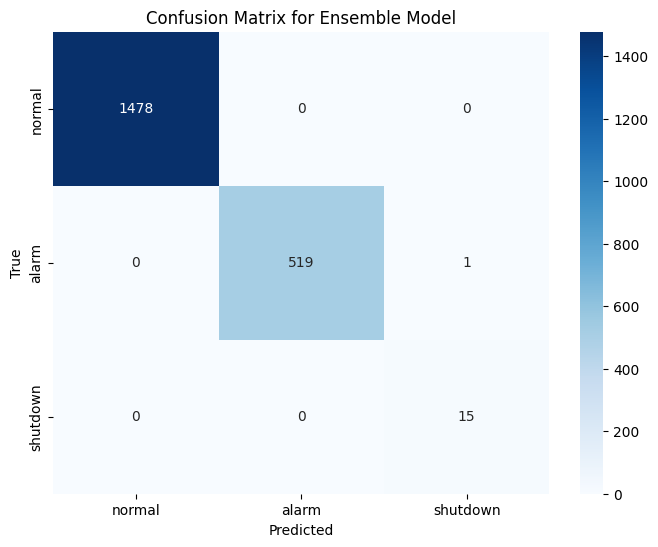

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Voting Classifier with soft voting
vc = VotingClassifier([('clf1', knn), ('clf2', svm), ('clf3', xgb), ('clf4', rf)], voting='soft')

# Train the classifier on the training data
vc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = vc.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()
